# Train one operator, test the other

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from keras.models import Sequential # type: ignore
from keras.layers import Dense, LSTM, Dropout # type: ignore
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go

In [112]:
rsrp_colors = ['#384959', '#6A89A7', '#88BDF2', '#BDDDFC']
rsrq_colors = ['#614419', '#B37E2E', '#DB9A39', '#FFB343']
sinr_colors = ['#135E4B', '#4CB572', '#A1D8B5', '#CCDCDB']
mode_colors = ['#872323', '#C93636', '#E26666', '#F4B6B6']

## Processing functions

In [113]:
'''
    Reading the dataset and returning two pandas DataFrames:
        The first DataFrame containing every datapoint belonging to the given campaign (if any)
        The second DataFrame containing only one column - the mode (4G or 5G)
'''
def read_dataset(filename, campaigns=None, features=None):
    df = pd.read_csv(filename)
    df = df.loc[:, ~df.columns.str.match('Unnamed')]
    df = df.loc[:, ~df.columns.str.match('Timestamp')]
    df = df.replace('DC', 1)
    df = df.replace('LTE', 0)
    df = df[df['campaign'].str.contains('Driving') | df['campaign'].str.contains('Walking')]

    if campaigns != None:
        df = df[df['campaign'].isin(campaigns)]

    if features == None:
        features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'campaign']

    features.append('Mode')
    features.append('Latitude')
    features.append('Longitude')
    return df[features]

## LSTM functions

In [149]:
'''
    Returns a numpy array of list 
'''
def series_split_sequences(f, t, n_steps_in, n_steps_out):
    X, y = [], []
    curr_campaign = ''
    for i in range(len(f)):
        # find the end of the pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        if out_end_ix > len(f):
            break

        if curr_campaign == '': # set new current campaign if there is no campaign
            curr_campaign = f['campaign'].iloc[i]
        seq_x, seq_y = f[i:end_ix], t[end_ix:out_end_ix]
        if f.iloc[i:out_end_ix]['campaign'].nunique() > 1: # check to see if in transition between two campaigns
            continue
        elif curr_campaign != f['campaign'].iloc[i]: # set new campaign equal to current if this is the campaign we are looping through
            curr_campaign = f['campaign'].iloc[i]
        X.append(seq_x.drop('campaign', axis=1))
        y.append(seq_y)

    return np.array(X), np.array(y)


'''
    Returns the mean absolute error on each datapoint
'''
def single_point_mae(y_pred, y_true):
    pred_series, true_series = [], []
    mae_list = []

    for i in range(len(y_pred)):
        mae = []
        for k in range(len(y_pred[i])):
            pred_series.append(y_pred[i][k])
            true_series.append(y_true[i][k])
            mae.append(np.abs(y_pred[i][k] - y_true[i][k]))
        mae_list.append(mae)

    pred_series, true_series = np.array(pred_series), np.array(true_series)

    return np.mean(np.abs(pred_series - true_series)), np.array(mae_list)


def long_short_term_memory(train, test, target_feature:str, features:list, campaigns:list, test_campaigns:list, n_steps_in=5, n_steps_out=1, n_first_units=5, n_second_units=10):

    features.remove('campaign')

    idx_target = features.index(target_feature)

    scaler = MinMaxScaler()
    train[features] = scaler.fit_transform(train[features])
    test[features] = scaler.transform(test[features])

    X, y = series_split_sequences(train, train[target_feature], n_steps_in, n_steps_out)
    X_test, y_test = series_split_sequences(test, test[target_feature], n_steps_in, n_steps_out)

    train_idx = 4 * len(y) // 5

    X_train, y_train = X[0 : train_idx], y[0 : train_idx]
    X_val, y_val = X[train_idx ::], y[train_idx ::]

    # optimizer = RMSprop(learning_rate=0.001, rho=0.9) # , epsilon=None) 

    model = Sequential()
    model.add(LSTM(units=n_first_units,
                   activation='relu', recurrent_activation='sigmoid',
                   return_sequences=True, return_state=False
                   ))
    model.add(Dropout(0.2))
    model.add(LSTM(units=n_second_units,
                   activation='relu', recurrent_activation='sigmoid',
                   return_sequences=False, return_state=False
                   ))
    model.add(Dropout(0.2))
    model.add(Dense(n_steps_out, activation='sigmoid'))
    model.compile(loss='mse', optimizer='adam')
    
    history = model.fit(X_train, y_train,
              epochs=100,
              validation_data=(X_val, y_val),
              shuffle=True, verbose=0)

    scaler_pred = MinMaxScaler()
    scaler_pred.min_, scaler_pred.scale_ = scaler.min_[idx_target], scaler.scale_[idx_target]

    y_pred = model.predict(X_test, verbose=0) 

    y_pred = scaler_pred.inverse_transform(y_pred)
    y_true = scaler_pred.inverse_transform(y_test)
    test[features] = scaler.inverse_transform(test[features])

    train_pred = model.predict(X, verbose=0)

    train_pred = scaler_pred.inverse_transform(train_pred)
    train[features] = scaler.inverse_transform(train[features])
    _, test_y_seq = series_split_sequences(train, train[target_feature], n_steps_in, n_steps_out)
        
    mae = single_point_mae(y_pred, y_true)
    train_mae = single_point_mae(train_pred, test_y_seq)

    if n_steps_out > 1:
        y_pred_plot, y_true_plot, train_pred_plot, train_true_plot = y_pred, y_true, train_pred, y_train
    else:
        # test data
        y_true_plot = test[target_feature].values
        y_pred_plot = np.empty_like(test[[target_feature]])
        y_pred_plot[:, :] = np.nan
        y_pred_plot[n_steps_in : len(y_pred) + n_steps_in, :] = y_pred

        # train data
        train[features] = scaler.inverse_transform(train[features])
        train_true_plot = train[target_feature].values
        train_pred_plot = np.empty_like(train[[target_feature]])
        train_pred_plot[:, :] = np.nan
        train_pred_plot[n_steps_in : len(train_pred) + n_steps_in, :] = train_pred

    results = {'y_pred': y_pred_plot,
               'y_true': y_true_plot,
               'train_pred': train_pred_plot,
               'train_true': train_true_plot,
               'loss' : history.history['loss'],
               'loss_final' : round(history.history['loss'][-1], 5),
               'val_loss' : history.history['val_loss'],
               'val_loss_final' : round(history.history['val_loss'][-1], 5),
               'mae': round(mae[0], 2),
               'list_mae': mae[1],
               'train_mae': round(train_mae[0], 2),
               'train_list_mae': train_mae[1]
               }

    return results

def plot_lstm_1_step(pred, true, colors:list, target_feature:str, operator:str, feature_comb:str, test_train:str):
    f = plt.figure(figsize=(16, 6))
    plt.grid(zorder=0)
    pred = plt.plot(pred, label='Predicted', color=colors[0], zorder=2)
    true = plt.plot(true, label='True', color=colors[2], zorder=1)
    plt.xlabel('Index / Timestamp')
    plt.ylabel(target_feature)
    plt.xlim((0, 200))
    plt.title(f'Prediction on {test_train} data\n{operator}\nCombination of training features: {feature_comb}')
    plt.legend(handles=[pred[0], true[0]])
    plt.show()

'''
    Plots the mean absolute errors in a boxplot for each signal strength indicator
    Returns a dataframe with mean mae for each timestep for each signal strength indicator
'''
def boxplot_timesteps(results:dict, feature_comb:list, sss_feature_comb:list, n_steps_out:int, operator:str, whiskers=[5, 95], y_lim=None):
    selected_rsrp, selected_sinr, selected_rsrq = feature_comb[0], feature_comb[1], feature_comb[2]
    selected_sss_rsrp, selected_sss_sinr, selected_sss_rsrq = sss_feature_comb[0], sss_feature_comb[1], sss_feature_comb[2]

    rsrp_lstm, sinr_lstm, rsrq_lstm = results[selected_rsrp]['list_mae'], results[selected_sinr]['list_mae'], results[selected_rsrq]['list_mae']
    sss_rsrp_lstm, sss_sinr_lstm, sss_rsrq_lstm = results[selected_sss_rsrp]['list_mae'], results[selected_sss_sinr]['list_mae'], results[selected_sss_rsrq]['list_mae']

    rsrp_lstm_mae, sinr_lstm_mae, rsrq_lstm_mae, sss_rsrp_lstm_mae, sss_sinr_lstm_mae, sss_rsrq_lstm_mae = [], [], [], [], [], []
    mean_rsrp, mean_sinr, mean_rsrq, mean_sss_rsrp, mean_sss_sinr, mean_sss_rsrq = [], [], [], [], [], []

    for i in range(n_steps_out):
        rsrp_lstm_mae.append(rsrp_lstm[:, i])
        mean_rsrp.append(round(np.mean(rsrp_lstm[:, i]), 3))

        sinr_lstm_mae.append(sinr_lstm[:, i])
        mean_sinr.append(round(np.mean(sinr_lstm[:, i]), 3))

        rsrq_lstm_mae.append(rsrq_lstm[:, i])
        mean_rsrq.append(round(np.mean(rsrq_lstm[:, i]), 3))

        sss_rsrp_lstm_mae.append(sss_rsrp_lstm[:, i])
        mean_sss_rsrp.append(round(np.mean(sss_rsrp_lstm[:, i]), 3))

        sss_sinr_lstm_mae.append(sss_sinr_lstm[:, i])
        mean_sss_sinr.append(round(np.mean(sss_sinr_lstm[:, i]), 3))

        sss_rsrq_lstm_mae.append(sss_rsrq_lstm[:, i])
        mean_sss_rsrq.append(round(np.mean(sss_rsrq_lstm[:, i]), 3))
    
    labels = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11th', '12th', '13th', '14th', '15th', '16th', '17th', '18th', '19th', '20th']

    fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=True)
    sns.boxplot(data=rsrp_lstm_mae, color=rsrp_colors[2], ax=axes[0, 0], whis=whiskers)
    axes[0, 0].set_title('Mean absolute errors of RSRP')

    sns.boxplot(data=sinr_lstm_mae, color=sinr_colors[2], ax=axes[0, 1], whis=whiskers)
    axes[0, 1].set_title('Mean absolute errors of SINR')

    sns.boxplot(data=rsrq_lstm_mae, color=rsrq_colors[2], ax=axes[0, 2], whis=whiskers)
    axes[0, 2].set_title('Mean absolute errors of RSRQ')

    sns.boxplot(data=sss_rsrp_lstm_mae, color=rsrp_colors[2], ax=axes[1, 0], whis=whiskers)
    axes[1, 0].set_title('Mean absolute errors of SSS-RSRP')

    sns.boxplot(data=sss_sinr_lstm_mae, color=sinr_colors[2], ax=axes[1, 1], whis=whiskers)
    axes[1, 1].set_title('Mean absolute errors of SSS-SINR')

    sns.boxplot(data=sss_rsrq_lstm_mae, color=rsrq_colors[2], ax=axes[1, 2], whis=whiskers)
    axes[1, 2].set_title('Mean absolute errors of SSS-RSRQ')

    axes[0, 0].set_ylim((-0.2, y_lim))

    for ax in axes.flat:
        ax.set_ylabel('Mean Absolute Error')
        ax.set_xlabel('Timestep')
        ax.set_xticks(range(n_steps_out))
        ax.set_xticklabels(labels[0:n_steps_out])
        
    plt.suptitle(f'{n_steps_out} Timesteps Ahead -- {operator}', fontsize=16, fontweight='semibold')

    plt.show()

    means = {
        'RSRP': mean_rsrp,
        'SINR': mean_sinr,
        'RSRQ': mean_rsrq,
        'SSS-RSRP': mean_sss_rsrp,
        'SSS-SINR': mean_sss_sinr,
        'SSS-RSRQ': mean_sss_rsrq
    }

    means = pd.DataFrame(means, index=labels[0:n_steps_out]).T

    return means

## Random Forest functions

In [115]:
def rf(X_train, X_test, mode_train, mode_test, campaigns, test_campaigns, features, n_estimators=100, max_depth=None, min_samples_leaf=1):
    permutation = np.random.permutation(X_train.index)
    X_train_randomized = X_train.reindex(permutation).reset_index(drop=True)
    mode_train_randomized = mode_train.reindex(permutation).reset_index(drop=True)

    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    smote = SMOTE()
    # rus = RandomUnderSampler() 
    X_train_balanced, mode_train_balanced = smote.fit_resample(X_train_randomized[features], mode_train_randomized['Mode'])
    # X_train_balanced, mode_train_balanced = rus.fit_resample(X_train_balanced, mode_train_balanced)

    rf.fit(X_train_balanced, mode_train_balanced)

    if len(test_campaigns) == 1:
        y_pred = rf.predict(X_test[features])

        accuracy = accuracy_score(mode_test['Mode'], y_pred)
        precision = precision_score(mode_test['Mode'], y_pred)
        recall = recall_score(mode_test['Mode'], y_pred)

        y_true = mode_test['Mode']

        

        train_pred = rf.predict(X_train[features])

        train_accuracy = accuracy_score(mode_train['Mode'], train_pred)
        train_precision = precision_score(mode_train['Mode'], train_pred)
        train_recall = recall_score(mode_train['Mode'], train_pred)

        train_true = mode_train['Mode']
    else:
        X_test_test = X_test[X_test['campaign'] == test_campaigns[0]]
        X_test_mode = mode_test[mode_test['campaign'] == test_campaigns[0]]
        
        y_pred = rf.predict(X_test_test[features])

        y_pred_total = rf.predict(X_test[features])
        accuracy = accuracy_score(mode_test['Mode'], y_pred_total)
        precision = precision_score(mode_test['Mode'], y_pred_total)
        recall = recall_score(mode_test['Mode'], y_pred_total)

        y_true = X_test_mode['Mode']

        X_train_test = X_train[X_train['campaign'] == campaigns[0]]
        X_train_mode = mode_train[mode_train['campaign'] == campaigns[0]]

        train_pred = rf.predict(X_train_test[features])

        train_pred_total = rf.predict(X_train[features])
        train_accuracy = accuracy_score(mode_train['Mode'], train_pred_total)
        train_precision = precision_score(mode_train['Mode'], train_pred_total)
        train_recall = recall_score(mode_train['Mode'], train_pred_total)

        train_true = X_train_mode['Mode']

    results = {'Accuracy': round(accuracy, 3),
               'Precision': round(precision, 3),
               'Recall': round(recall, 3),
               'y_true' : y_true,
               'y_pred' : y_pred,
               'train_true': train_true,
               'train_pred': train_pred,
               'Accuracy_train': round(train_accuracy, 3),
               'Precision_train': round(train_precision, 3),
               'Recall_train': round(train_recall, 3),
               'model': rf}
    return results

def plot_mode(pred, true, operator:str, comb:str, campaigns:list, test_campaigns:list, test_train='Test', colors=mode_colors):
    f = plt.figure(figsize=(16, 6))
    plt.grid(zorder=0)
    plt.plot(pred, color=colors[1], label='Predicted', zorder=2)
    plt.plot(true + 2, color=colors[3], label='True', zorder=3)
    plt.xlabel('Index / Timestamp')
    plt.ylabel('HO')
    plt.ylim((-0.2, 3.4))
    plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
    plt.title(f'{test_train} data -- {operator}\nParameters: {comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
    plt.legend(ncols=3, loc='best')
    plt.show()

In [116]:
# Parameters
tf.random.set_seed(4567)
op1_dataset = 'datasets/Op1_merged.csv'
op2_dataset = 'datasets/Op2_merged.csv'
operator = 'Train on Operator 1 - Test on Operator 2'

# LSTM
n_steps_in = 2
n_steps_out = 1

n_first_units = 5
n_second_units = 10

# Random Forest
n_estimators = 100
max_depth = 10

In [117]:
op1_overlap = ['Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi_Test_2_No_Flight_Mode',
               'Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi',
               'Interactivity_gaming_4G5G_TIM_Driving_Viale_Marconi_No_Flight_Mode', 
               'Capacity_Ookla_UNIDATA_4G5G_TIM_Driving_Viale_Marconi',
               'Interactivity_gaming_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode',
               'Ping_UNIDATA_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode']

op2_overlap = ['Ping_UNIDATA_4G5G_Vodafone_Driving_Viale_Marconi_Test_2_No_Flight_Mode', 
               'Ping_8888_4G5G_Vodafone_Driving_Viale_Marconi_No_Flight_Mode', 
               'Capacity_Ookla_UNIDATA_4G5G_Vodafone_Driving_Viale_Marconi', 
               'Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End_to_Eur_Palasport_No_Flight_Mode']

In [118]:
# train is only Operator 1
train = read_dataset(op1_dataset, campaigns=op1_overlap[0:4])

# only a part of this route overlaps with the others
route_to_add = read_dataset(op1_dataset, campaigns=[op1_overlap[4]])
train = pd.concat([route_to_add[5400::], train])
train.reset_index(drop=True, inplace=True)

# only a part of this route overlaos with the others
route_to_add = read_dataset(op1_dataset, campaigns=[op1_overlap[5]])
train = pd.concat([route_to_add[0:1180], train])
train.reset_index(drop=True, inplace=True)

campaigns = train['campaign'].unique().tolist()

# test is only Operator 2
test = read_dataset(op2_dataset, campaigns=op2_overlap[0:3])
test_campaigns = test['campaign'].unique().tolist()

# only a part of this route overlaos with the others
route_to_add = read_dataset(op2_dataset, campaigns=[op2_overlap[3]])
test = pd.concat([route_to_add[5350::], test])
test.reset_index(drop=True, inplace=True)

fig = go.Figure()
fig.add_trace(go.Scattermapbox(lat=train['Latitude'], lon=train['Longitude'],
                                marker = dict(
                                    opacity = 1,
                                    size = 3,
                                    color=rsrp_colors[2]
                                ),
                                name='Train'))
fig.add_trace(go.Scattermapbox(lat=test['Latitude'], lon=test['Longitude'],
                                marker = dict(
                                    opacity = 0.2,
                                    size = 3,
                                    color=mode_colors[2]
                                ),
                                name='Test'))

fig.update_layout(
    height=420,
    width=400,
    mapbox=dict(
        style='carto-positron',
        zoom=11.3,
        center=dict(lon=train['Longitude'].mean(), lat=train['Latitude'].mean())
    ),
    margin=dict(
        t=1,
        b=1,
        r=1,
        l=1
    )
)
fig.show()

## LSTM - 1 step

Train on Operator 1 - Test on Operator 2

In [119]:
target_features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']
feature_selection = [#['RSRP'], ['SINR'], ['RSRQ'], 
                    #  ['RSRP', 'SINR'], ['RSRP', 'RSRQ'], ['SINR', 'RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ'],
                     #['SSS_RSRP'], ['SSS_SINR'], ['SSS_RSRQ'],
                    #  ['SSS_RSRP', 'SSS_SINR'], ['SSS_RSRP', 'SSS_RSRQ'], ['SSS_SINR', 'SSS_RSRQ'], 
                     ['SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'],
                     ['RSRP', 'SSS_RSRP'], ['SINR', 'SSS_SINR'], ['RSRQ', 'SSS_RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']]

lstm_results = {}

In [120]:
for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=campaigns, test_campaigns=test_campaigns, n_first_units=n_first_units, n_second_units=n_second_units)

In [121]:
df_lstm_results = pd.DataFrame.from_dict(lstm_results, orient='index')

df_lstm_results.reset_index(inplace=True)
df_lstm_results.rename(columns={'index': 'Combination'}, inplace=True)
df_lstm_results = df_lstm_results.drop(['y_pred', 'y_true', 'train_pred', 'train_true', 'loss', 'val_loss', 'list_mae', 'train_list_mae'], axis=1)
df_lstm_results

,Combination,loss_final,val_loss_final,mae,train_mae
0,"RSRP, SINR, RSRQ -> RSRP",0.00292,0.00375,2.59,100.93
1,"RSRP, SSS_RSRP -> RSRP",0.00257,0.00318,2.40,100.73
2,All -> RSRP,0.00719,0.00634,2.99,98.53
3,"RSRP, SINR, RSRQ -> SINR",0.00217,0.00243,2.47,6.36
4,"SINR, SSS_SINR -> SINR",0.00254,0.00309,2.82,6.05
5,All -> SINR,0.00181,0.00178,1.72,6.94
6,"RSRP, SINR, RSRQ -> RSRQ",0.00291,0.00232,0.48,17.36
7,"RSRQ, SSS_RSRQ -> RSRQ",0.00262,0.00172,0.32,17.47
8,All -> RSRQ,0.00476,0.00438,1.10,18.27
9,"SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_RSRP",0.00433,0.00624,3.33,119.37


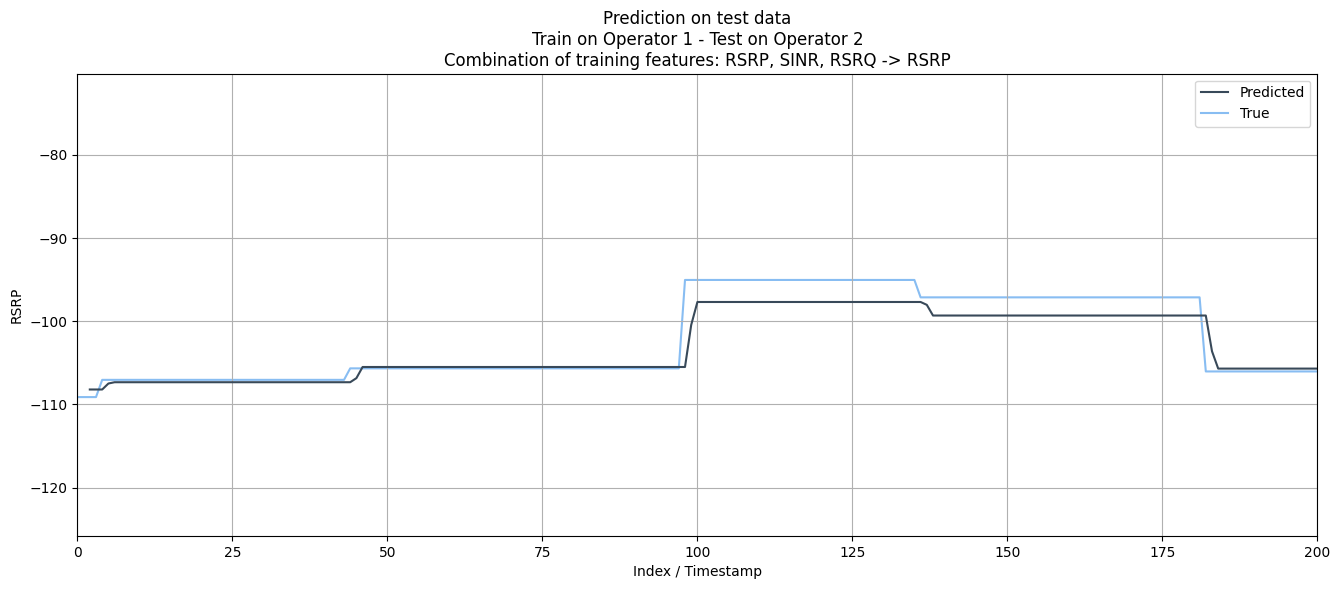

In [122]:
selected_rsrp_comb = 'RSRP, SINR, RSRQ -> RSRP'
rsrp_comb = lstm_results[selected_rsrp_comb]
rsrp_pred = rsrp_comb['y_pred']
rsrp_true = rsrp_comb['y_true']
rsrp_train_pred = rsrp_comb['train_pred']
rsrp_train_true = rsrp_comb['train_true']

plot_lstm_1_step(pred=rsrp_pred, true=rsrp_true, colors=rsrp_colors, target_feature='RSRP', operator=operator, feature_comb=selected_rsrp_comb, test_train='test')

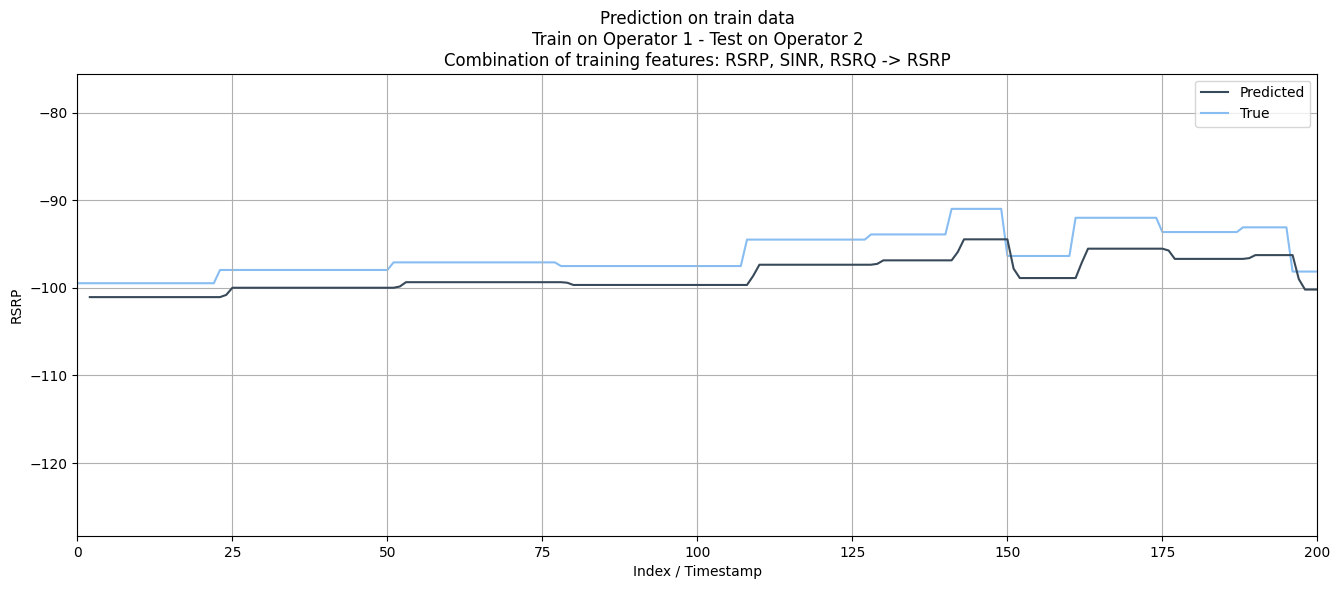

In [123]:
plot_lstm_1_step(pred=rsrp_train_pred, true=rsrp_train_true, colors=rsrp_colors, target_feature='RSRP', operator=operator, feature_comb=selected_rsrp_comb, test_train='train')

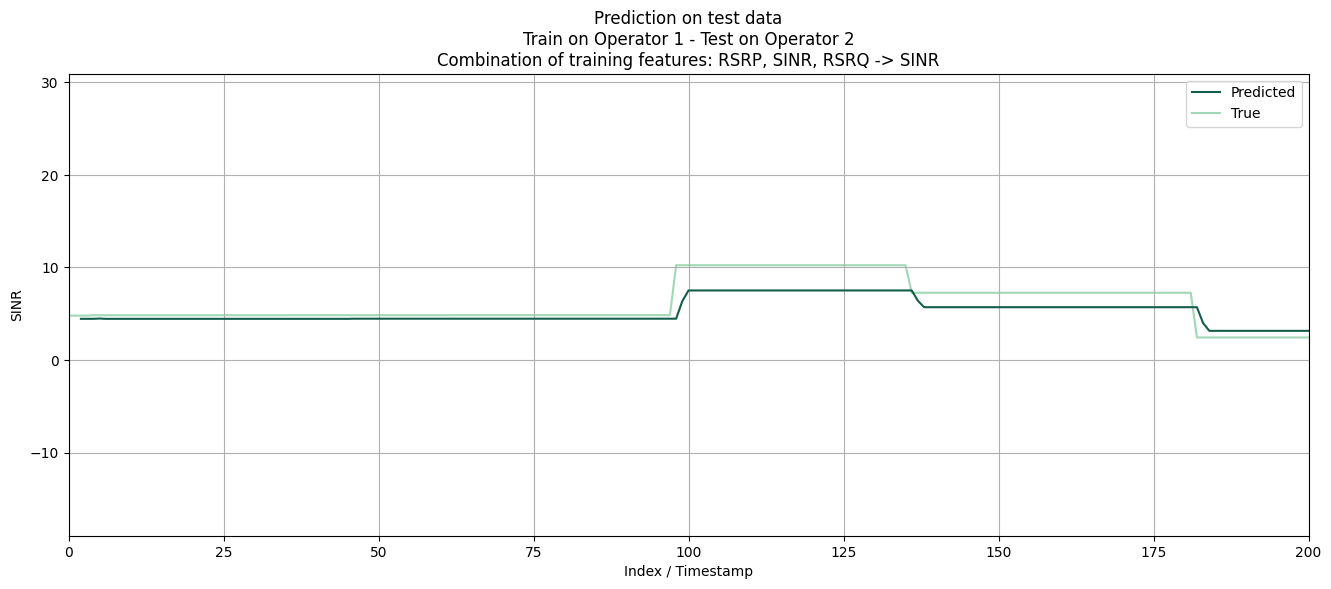

In [124]:
selected_sinr_comb = 'RSRP, SINR, RSRQ -> SINR'
sinr_comb = lstm_results[selected_sinr_comb]
sinr_pred = sinr_comb['y_pred']
sinr_true = sinr_comb['y_true']
sinr_train_pred = sinr_comb['train_pred']
sinr_train_true = sinr_comb['train_true']

plot_lstm_1_step(pred=sinr_pred, true=sinr_true, colors=sinr_colors, target_feature='SINR', operator=operator, feature_comb=selected_sinr_comb, test_train='test')

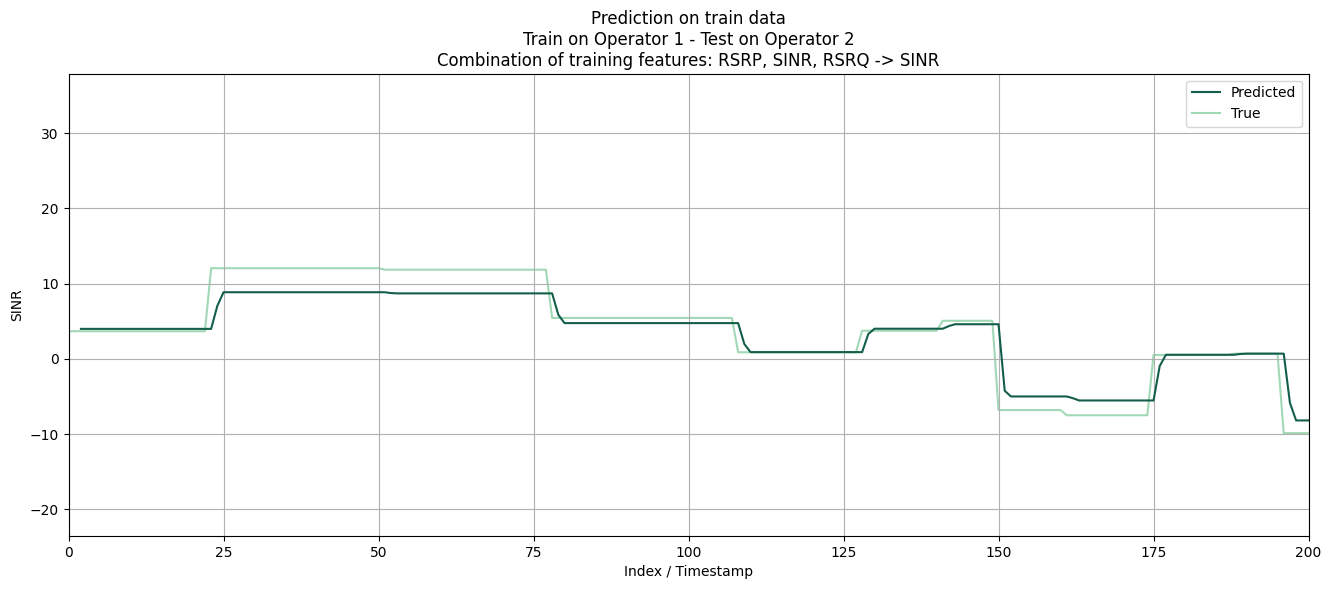

In [125]:
plot_lstm_1_step(pred=sinr_train_pred, true=sinr_train_true, colors=sinr_colors, target_feature='SINR', operator=operator, feature_comb=selected_sinr_comb, test_train='train')

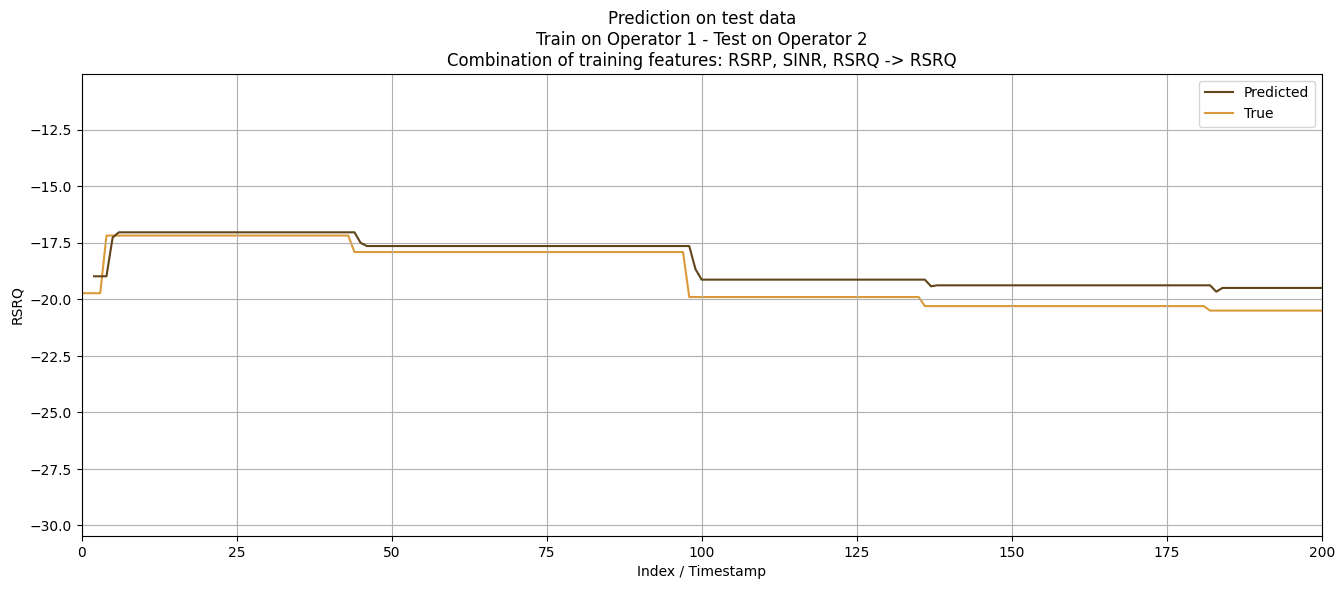

In [126]:
selected_rsrq_comb = 'RSRP, SINR, RSRQ -> RSRQ'
rsrq_comb = lstm_results[selected_rsrq_comb]
rsrq_pred = rsrq_comb['y_pred']
rsrq_true = rsrq_comb['y_true']
rsrq_train_pred = rsrq_comb['train_pred']
rsrq_train_true = rsrq_comb['train_true']

plot_lstm_1_step(pred=rsrq_pred, true=rsrq_true, colors=rsrq_colors, target_feature='RSRQ', operator=operator, feature_comb=selected_rsrq_comb, test_train='test')

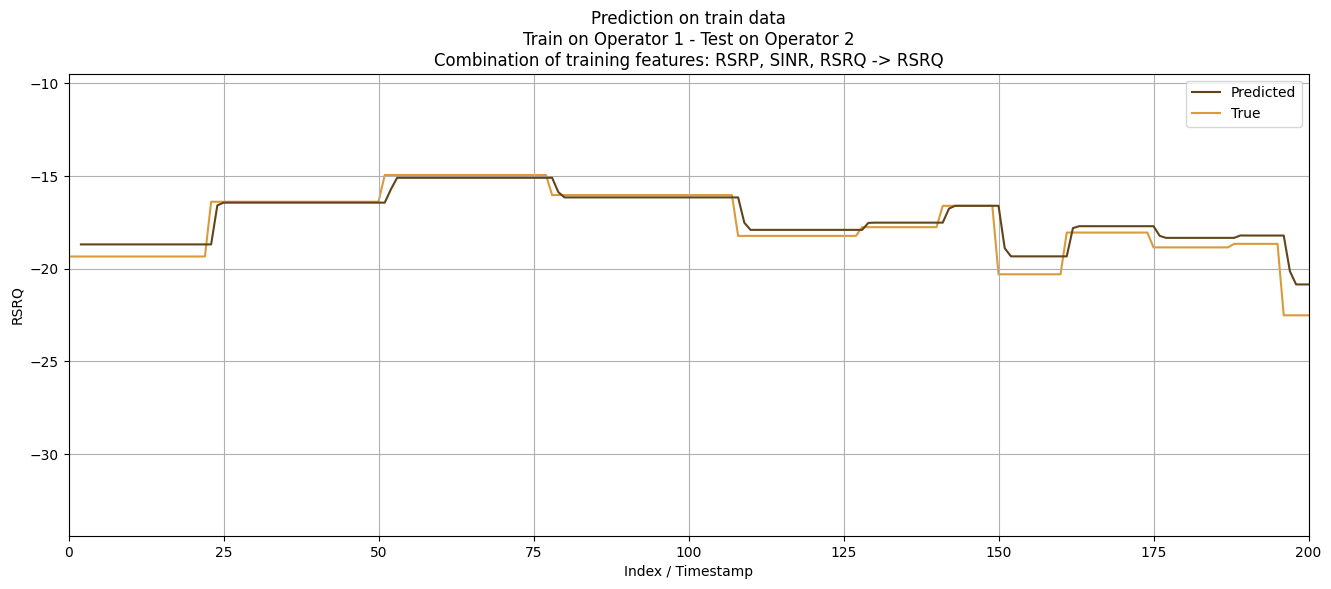

In [127]:
plot_lstm_1_step(pred=rsrq_train_pred, true=rsrq_train_true, colors=rsrq_colors, target_feature='RSRQ', operator=operator, feature_comb=selected_rsrq_comb, test_train='train')

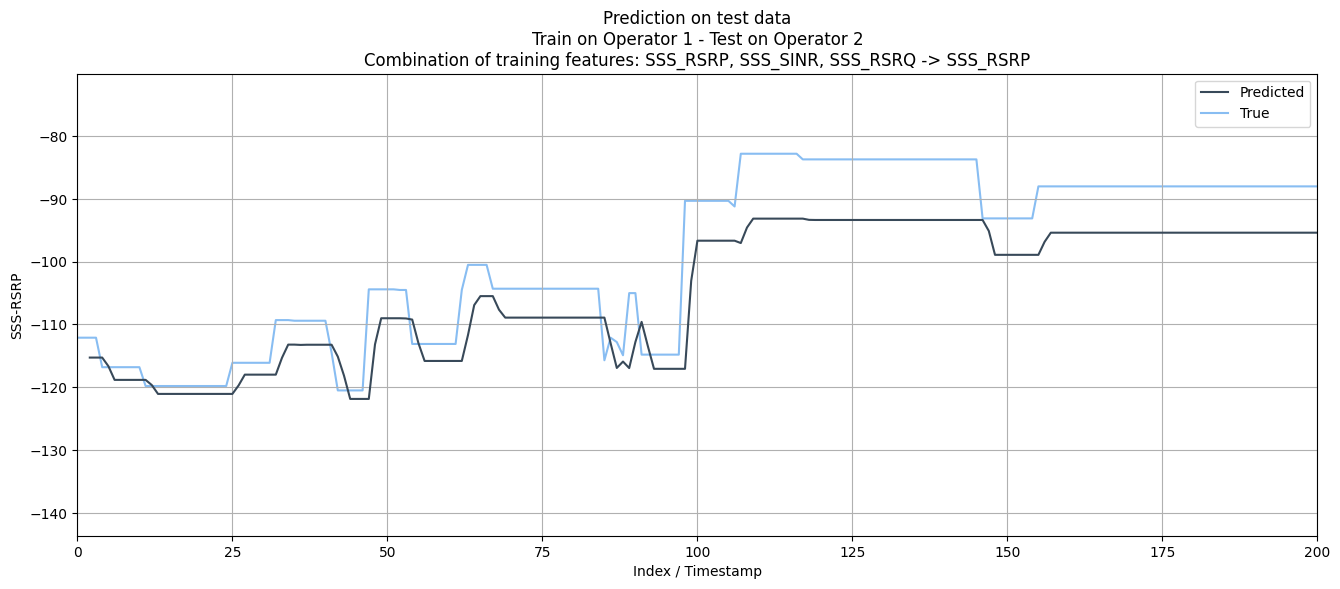

In [128]:
selected_sss_rsrp_comb = 'SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_RSRP'
sss_rsrp_comb = lstm_results[selected_sss_rsrp_comb]
sss_rsrp_pred = sss_rsrp_comb['y_pred']
sss_rsrp_true = sss_rsrp_comb['y_true']
sss_rsrp_train_pred = sss_rsrp_comb['train_pred']
sss_rsrp_train_true = sss_rsrp_comb['train_true']

plot_lstm_1_step(pred=sss_rsrp_pred, true=sss_rsrp_true, colors=rsrp_colors, target_feature='SSS-RSRP', operator=operator, feature_comb=selected_sss_rsrp_comb, test_train='test')

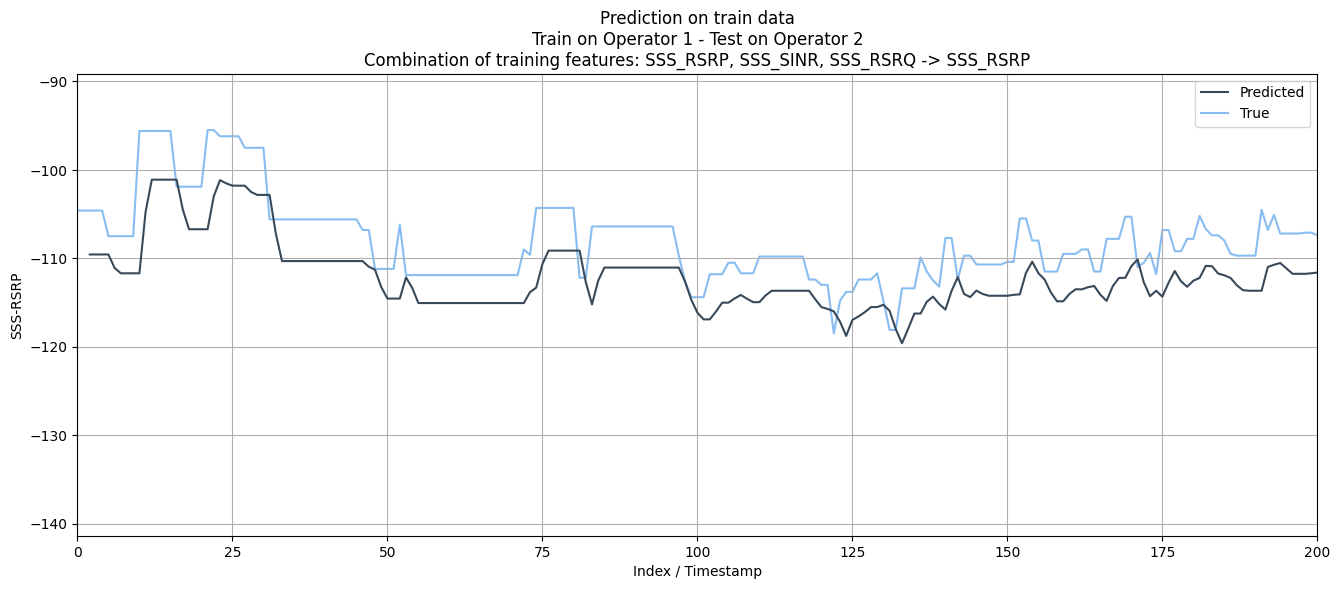

In [129]:
plot_lstm_1_step(pred=sss_rsrp_train_pred, true=sss_rsrp_train_true, colors=rsrp_colors, target_feature='SSS-RSRP', operator=operator, feature_comb=selected_sss_rsrp_comb, test_train='train')

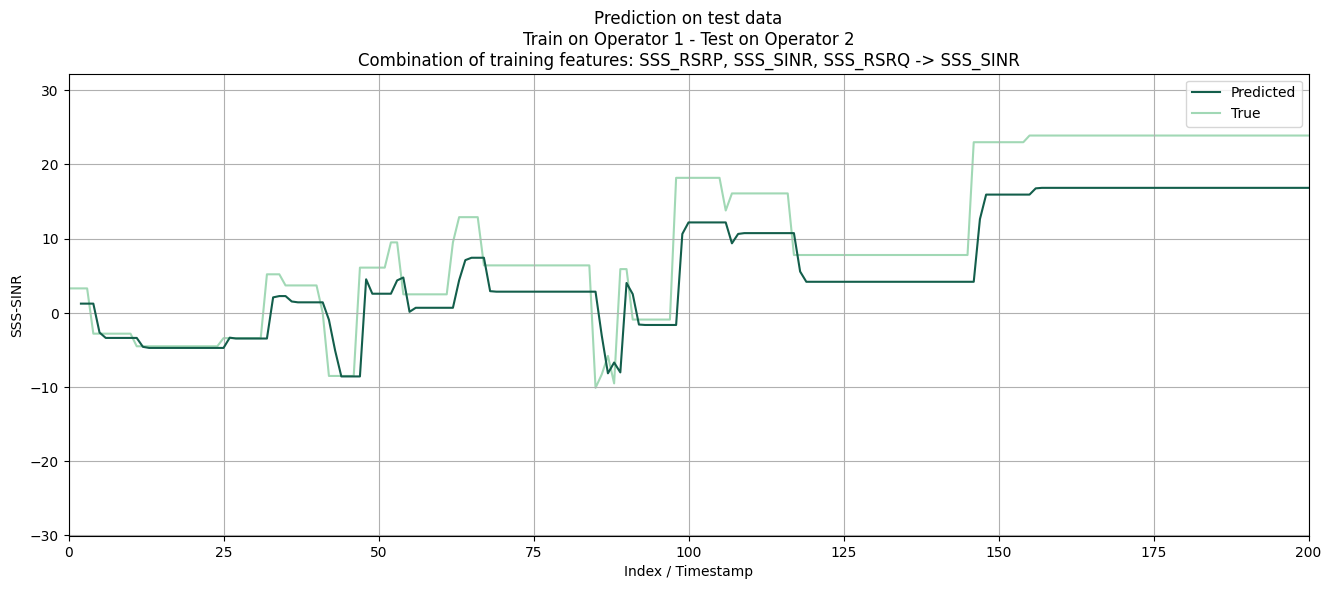

In [130]:
selected_sss_sinr_comb = 'SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_SINR'
sss_sinr_comb = lstm_results[selected_sss_sinr_comb]
sss_sinr_pred = sss_sinr_comb['y_pred']
sss_sinr_true = sss_sinr_comb['y_true']
sss_sinr_train_pred = sss_sinr_comb['train_pred']
sss_sinr_train_true = sss_sinr_comb['train_true']

plot_lstm_1_step(pred=sss_sinr_pred, true=sss_sinr_true, colors=sinr_colors, target_feature='SSS-SINR', operator=operator, feature_comb=selected_sss_sinr_comb, test_train='test')

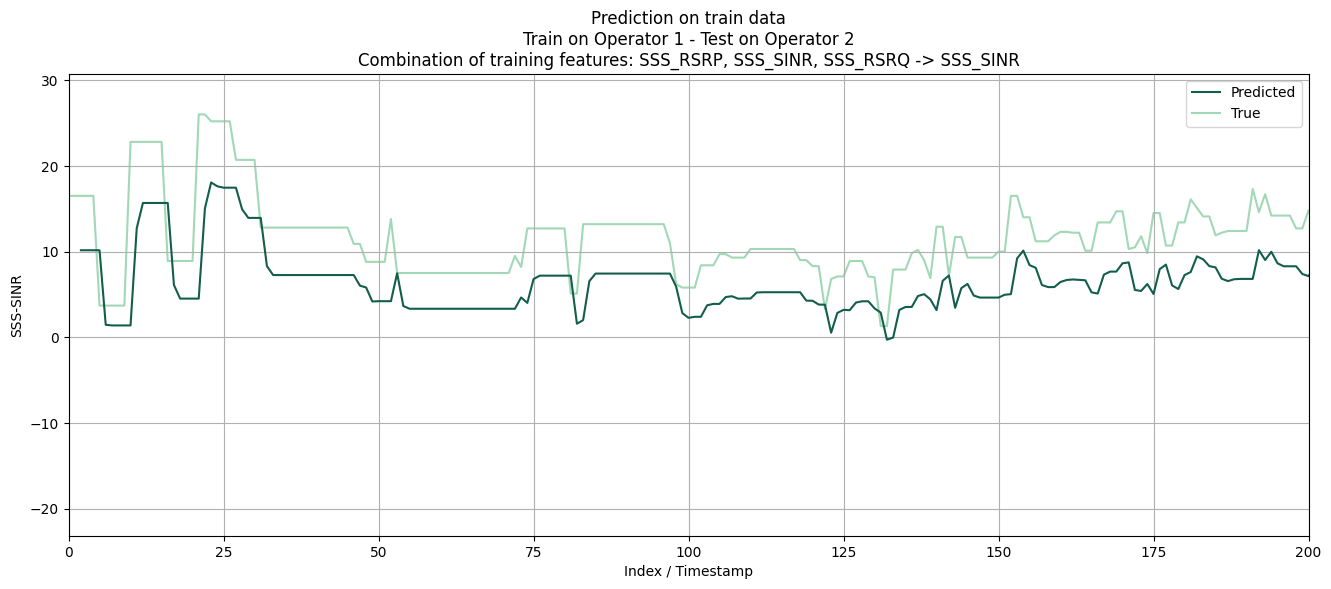

In [131]:
plot_lstm_1_step(pred=sss_sinr_train_pred, true=sss_sinr_train_true, colors=sinr_colors, target_feature='SSS-SINR', operator=operator, feature_comb=selected_sss_sinr_comb, test_train='train')

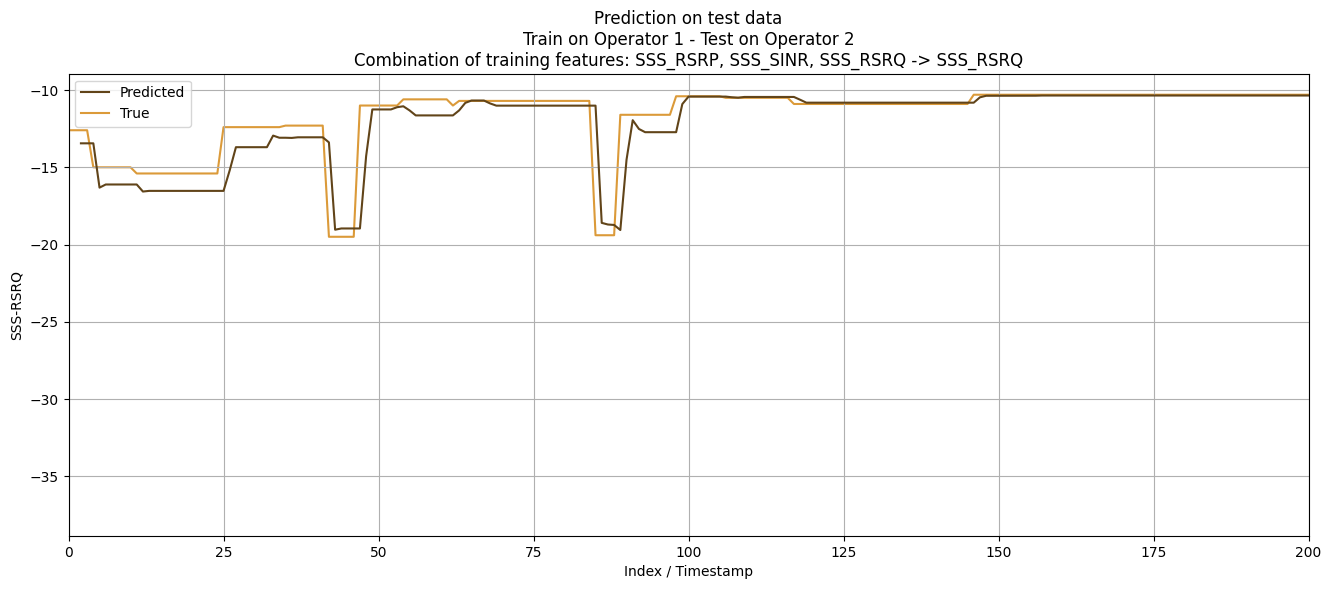

In [132]:
selected_sss_rsrq_comb = 'SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_RSRQ'
sss_rsrq_comb = lstm_results[selected_sss_rsrq_comb]
sss_rsrq_pred = sss_rsrq_comb['y_pred']
sss_rsrq_true = sss_rsrq_comb['y_true']
sss_rsrq_train_pred = sss_rsrq_comb['train_pred']
sss_rsrq_train_true = sss_rsrq_comb['train_true']

plot_lstm_1_step(pred=sss_rsrq_pred, true=sss_rsrq_true, colors=rsrq_colors, target_feature='SSS-RSRQ', operator=operator, feature_comb=selected_sss_rsrq_comb, test_train='test')

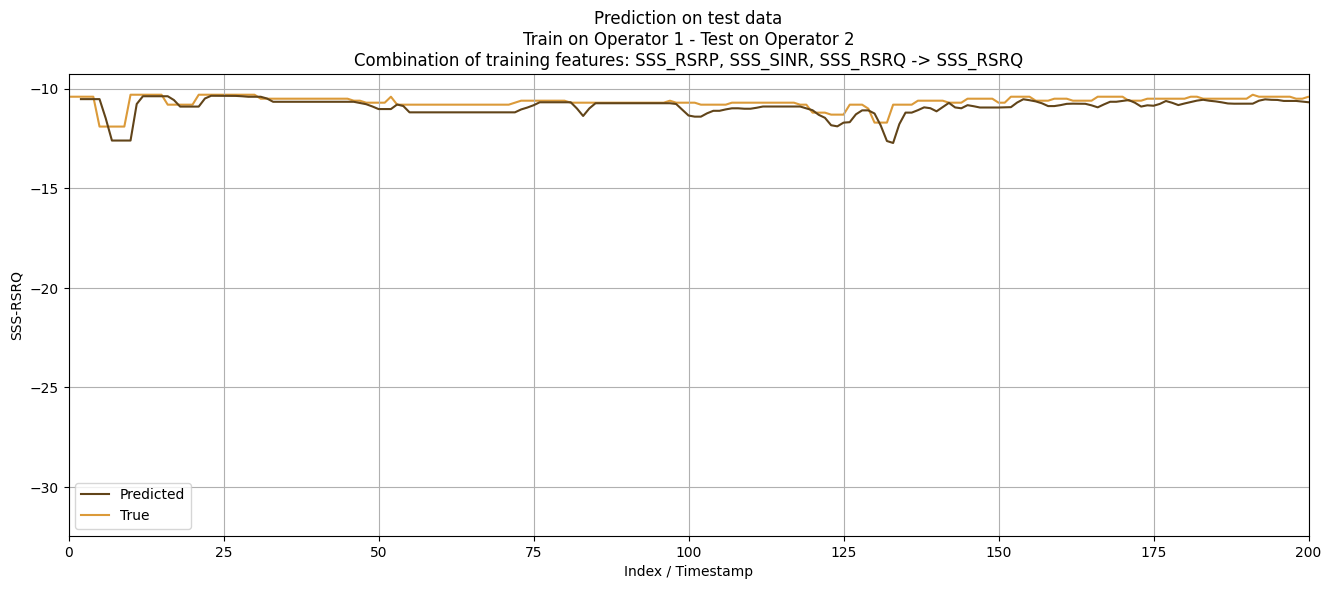

In [133]:
plot_lstm_1_step(pred=sss_rsrq_train_pred, true=sss_rsrq_train_true, colors=rsrq_colors, target_feature='SSS-RSRQ', operator=operator, feature_comb=selected_sss_rsrq_comb, test_train='test')

## LSTM - 5 step

Train on Operator 1 - Test on Operator 2

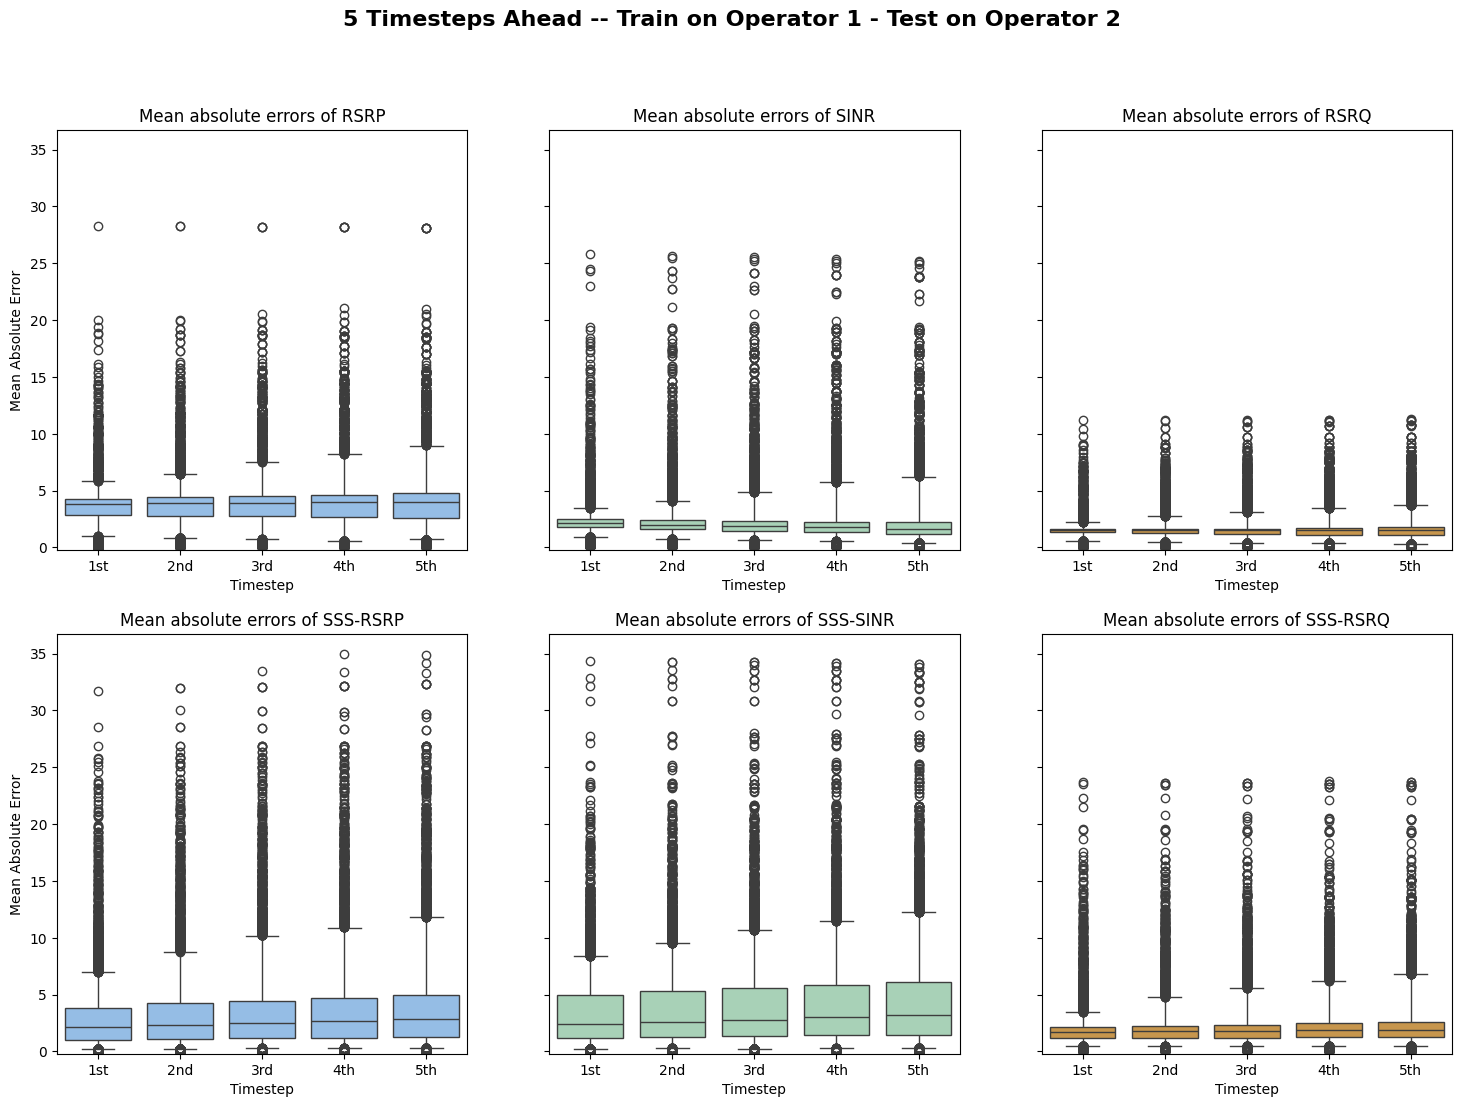

In [150]:
feature_comb = ['RSRP, SINR, RSRQ -> RSRP', 'RSRP, SINR, RSRQ -> SINR', 'RSRP, SINR, RSRQ -> RSRQ']
sss_feature_comb = ['SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_RSRP', 'SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_SINR', 'SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_RSRQ']

n_steps_in = 5
n_steps_out = 5

lstm_results = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=train['campaign'].unique().tolist(), test_campaigns=test['campaign'].unique().tolist(), n_first_units=n_first_units, n_second_units=n_second_units)
            df_lstm_results = pd.DataFrame.from_dict(lstm_results, orient='index')

mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_out=n_steps_out, operator=operator)

In [151]:
mae_each_step

,1st,2nd,3rd,4th,5th
RSRP,3.678,3.795,3.859,3.958,4.021
SINR,2.259,2.213,2.228,2.212,2.198
RSRQ,1.525,1.566,1.573,1.602,1.625
SSS-RSRP,2.751,3.144,3.443,3.720,3.965
SSS-SINR,3.314,3.650,3.910,4.162,4.394
SSS-RSRQ,1.863,2.034,2.176,2.299,2.401


- Se om jeg kan omgjøre gps dataen til en kolonne i stedet for lat og long

- Må legge RF oppå LSTM, teste med det vinduet og se på accuracy som beskrevet tidligere


----

- er det buffer periode mellom ho? for å unngå pingpong effekt (hysterizis). Range of theshold?


- Marker rett og gale svar med farge og scatterplot for å se om det er et sånn 'range of theshold': plot med yakse: sss-rsrp, x-akse:rsrp maybe?? experiment with parameters


- ss og vanlig er inne 1:1 comparable men begge er logaritmic


- Burde starte med å plotte bare 4G, 5G på samme måte